In [53]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import dates
import numpy as np
from datetime import timedelta
from dateutil.relativedelta import relativedelta


In [25]:
def concat_dfs(folder_path):
    # folder_path = 'parsed_data/auxilio_emergencial'

    file_names = os.listdir(folder_path)

    df = pd.DataFrame([])

    total_rows = 0

    for file in file_names:
        date = file[:-4]
        path = os.path.join(folder_path, file)
        if df.empty:
            df = pd.read_csv(path)
            df["date"] = pd.to_datetime(date, format="%Y%m")
            total_rows += len(df)
        else:
            next_df = pd.read_csv(path)
            next_df["date"] = pd.to_datetime(date, format="%Y%m")
            total_rows += len(next_df)
            df = pd.concat([df, next_df], ignore_index=True)

    df.sort_values("date", ascending=True)

    assert len(df) == total_rows

    return df


In [26]:
data_type = "files"  # files ou api

auxilio_emergencial = concat_dfs(
    f"parsed_data/auxilio_emergencial/{data_type}"
)
bolsa_familia = concat_dfs(f"parsed_data/bolsa_familia/{data_type}")
suicidios = pd.read_csv("parsed_data/suicidios/suicidios.csv")
suicidios["date"] = pd.to_datetime(suicidios["date"])
suicidios["municipio_ibge"] = suicidios["municipio_ibge"].astype(float)


In [27]:
def substituir_cod_municipio(df):
    # Substituir cod municipio siafi por ibge
    municipios = pd.read_csv("raw_data/codigo_municipios/TABMUN.csv")

    siafi_ibge_lookup = {}
    for row in municipios.iterrows():
        cod_siafi = row[1]["cod_siafi"]
        cod_ibge = row[1]["cod_ibge"]

        siafi_ibge_lookup[cod_siafi] = cod_ibge

    if "municipio_siafi" not in df:
        print("DF sem código siafi")
        return df

    df["municipio_siafi"] = df["municipio_siafi"].replace(siafi_ibge_lookup)

    df.columns = ["municipio_ibge", "contagem", "soma", "date"]

    return df


bolsa_familia = substituir_cod_municipio(bolsa_familia)


In [28]:
df_all = pd.merge(
    bolsa_familia,
    auxilio_emergencial,
    on=["municipio_ibge", "date"],
    how="outer",
)


In [29]:
df_all = pd.merge(
    df_all, suicidios, on=["municipio_ibge", "date"], how="outer"
)


In [30]:
df_all


,municipio_ibge,contagem_x,soma_x,date,soma_y,contagem_y,suicidios,obitos_totais,taxa_suicidio
0,1200104.0,3336.0,664577.0,2020-11-01,4622789.0,10827.0,NaN,NaN,NaN
1,1200203.0,10146.0,3369814.0,2020-11-01,10443021.0,26725.0,1.0,32.0,0.031250
2,1200336.0,3192.0,1092459.0,2020-11-01,1727939.0,6121.0,NaN,NaN,NaN
3,1200302.0,4887.0,1464602.0,2020-11-01,3398382.0,10504.0,NaN,NaN,NaN
4,1200401.0,25115.0,5789345.0,2020-11-01,56569756.0,111041.0,1.0,197.0,0.005076
...,...,...,...,...,...,...,...,...,...
171158,520000.0,NaN,NaN,2020-09-01,NaN,NaN,1.0,8.0,0.125000
171159,330000.0,NaN,NaN,2020-10-01,NaN,NaN,1.0,74.0,0.013514
171160,350000.0,NaN,NaN,2020-10-01,NaN,NaN,1.0,35.0,0.028571
171161,330000.0,NaN,NaN,2020-11-01,NaN,NaN,1.0,76.0,0.013158


In [31]:
if data_type == "files":
    df_all.columns = [
        "municipio_ibge",
        "beneficiarios_bolsa_familia",
        "valor_bolsa_familia",
        "date",
        "valor_auxilio_emergencial",
        "beneficiarios_auxilio_emergencial",
        "suicidios",
        "obitos_totais",
        "taxa_suicidio",
    ]
else:
    df_all.columns = [
        "municipio_ibge",
        "beneficiarios_bolsa_familia",
        "valor_bolsa_familia",
        "date",
        "beneficiarios_auxilio_emergencial",
        "valor_auxilio_emergencial",
        "suicidios",
        "obitos_totais",
        "taxa_suicidio",
    ]

df_all = df_all.fillna(0)


In [32]:
df_all["valor_total"] = (
    df_all["valor_bolsa_familia"] + df_all["valor_auxilio_emergencial"]
)


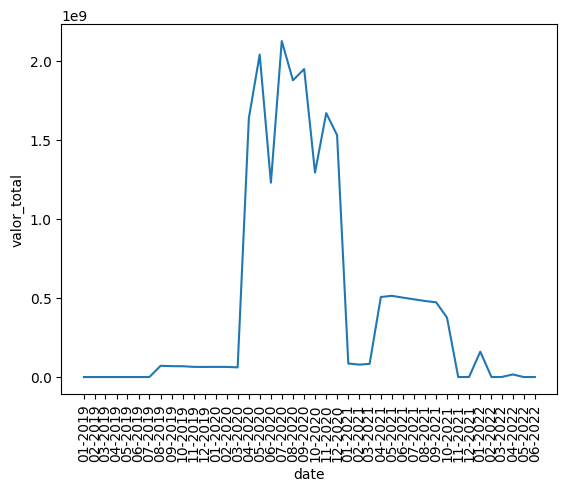

In [33]:
data = df_all[df_all["municipio_ibge"] == 3550308]
ax = sns.lineplot(data=data, x="date", y="valor_total")
ax.set(xticks=data.date.values)
ax.xaxis.set_major_formatter(dates.DateFormatter("%m-%Y"))
plt.xticks(rotation=90)
plt.show()


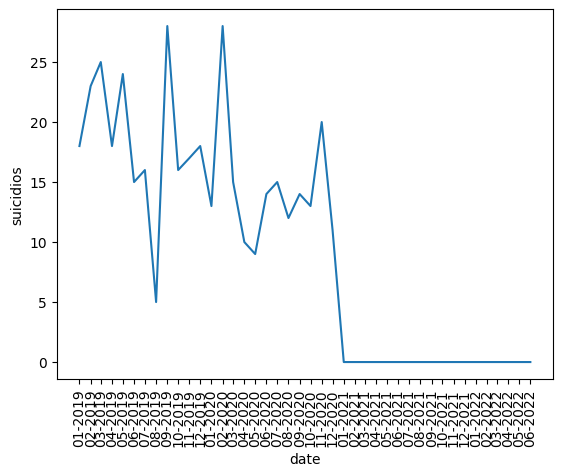

In [34]:
data = df_all[df_all["municipio_ibge"] == 3550308]
ax = sns.lineplot(data=data, x="date", y="suicidios")
ax.set(xticks=data.date.values)
ax.xaxis.set_major_formatter(dates.DateFormatter("%m-%Y"))
plt.xticks(rotation=90)
plt.show()


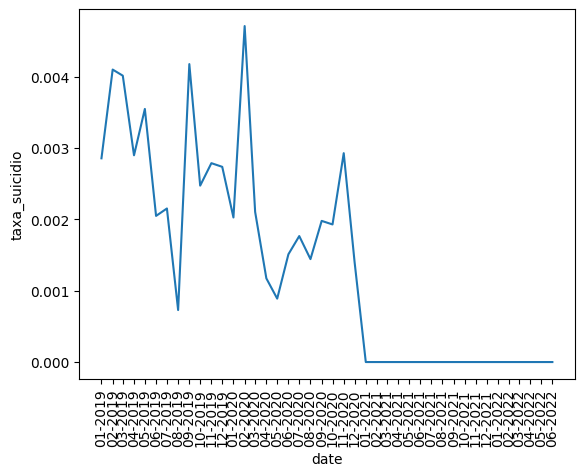

In [35]:
data = df_all[df_all["municipio_ibge"] == 3550308]
ax = sns.lineplot(data=data, x="date", y="taxa_suicidio")
ax.set(xticks=data.date.values)
ax.xaxis.set_major_formatter(dates.DateFormatter("%m-%Y"))
plt.xticks(rotation=90)
plt.show()


In [36]:
df_all["valor_medio"] = df_all["valor_total"] / (
    df_all["beneficiarios_auxilio_emergencial"]
    + df_all["beneficiarios_bolsa_familia"]
)


0.0008175065155539198
-0.001060045801526353


<AxesSubplot: xlabel='delta_suicidio', ylabel='percentil'>

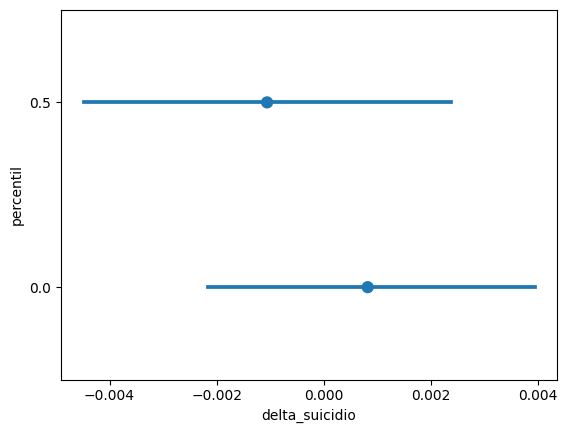

In [210]:
df_202003 = df_all[df_all["date"] == "2020-03-01"]
df_202004 = df_all[df_all["date"] == "2020-04-01"]

colunas_relevantes = ["municipio_ibge", "valor_medio", "taxa_suicidio"]

df_202003_rel = df_202003[colunas_relevantes]
df_202004_rel = df_202004[colunas_relevantes]

# df_202003_202004 = pd.merge(df_202003_rel, df_202004_rel)
df_202003_202004 = pd.merge(
    df_202003_rel, df_202004_rel, on=["municipio_ibge"]
)
df_202003_202004["variacao"] = (
    df_202003_202004["valor_medio_y"] - df_202003_202004["valor_medio_x"]
)

divisao = 2
df_divisions = np.array_split(
    df_202003_202004.sort_values("variacao"), divisao
)
for i, dfs_division in enumerate(df_divisions):
    indices = dfs_division.index
    df_202003_202004.loc[indices, "percentil"] = i / divisao

df_202003_202004["delta_suicidio"] = (
    df_202003_202004["taxa_suicidio_y"] - df_202003_202004["taxa_suicidio_x"]
)

for i, df_percentil in enumerate(df_divisions):
    print(
        df_percentil["taxa_suicidio_y"].mean()
        - df_percentil["taxa_suicidio_x"].mean()
    )

sns.pointplot(
    data=df_202003_202004,
    x="delta_suicidio",
    y="percentil",
    join=False,
    orient="h",
    order=-np.sort(-df_202003_202004["percentil"].unique()),
)


2020-03-01 00:00:00
2020-04-01 00:00:00
0.0013805282156996428
0.001014111687419916
-0.0026475176888950108
0.0017099944656960835
-0.002063464894851704


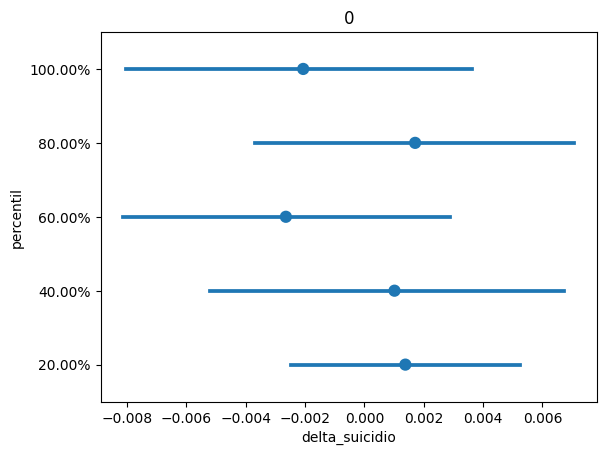

2020-02-01 00:00:00
2020-05-01 00:00:00
0.001584824118465663
-2.140736791827677e-05
-0.0011313592524555202
-0.0028027188485435766
-0.003422798010171632


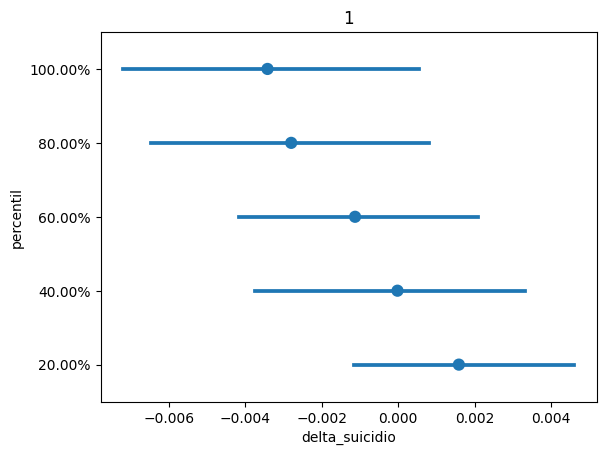

2019-12-01 00:00:00
2020-07-01 00:00:00
-2.1529714477365458e-05
-0.001137718310949708
-0.0027871130741078075
-0.004020082224819517
-0.004423676939608689


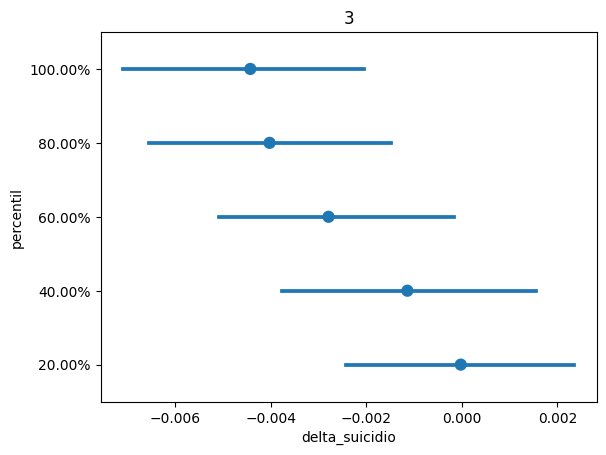

2019-09-01 00:00:00
2020-10-01 00:00:00
-0.00017422828531033635
-0.0016399243401962922
-0.0004916768983445046
-0.0030475939296670043
-0.003807533359747702


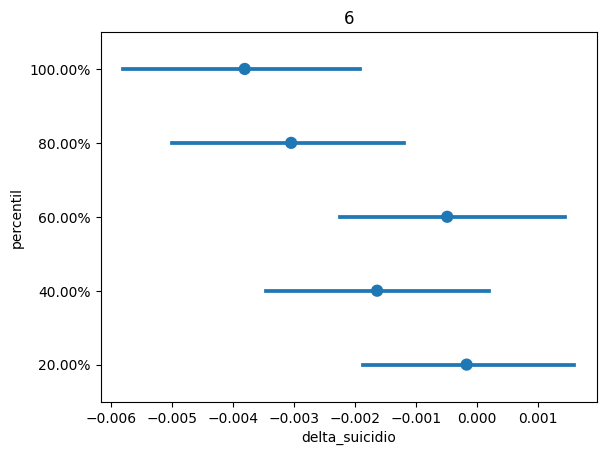

2019-07-01 00:00:00
2020-12-01 00:00:00
-0.0014981689809938047
-0.0023669022464168823
-0.0014360878825335262
-0.0035989624797567957
-0.004163376810972083


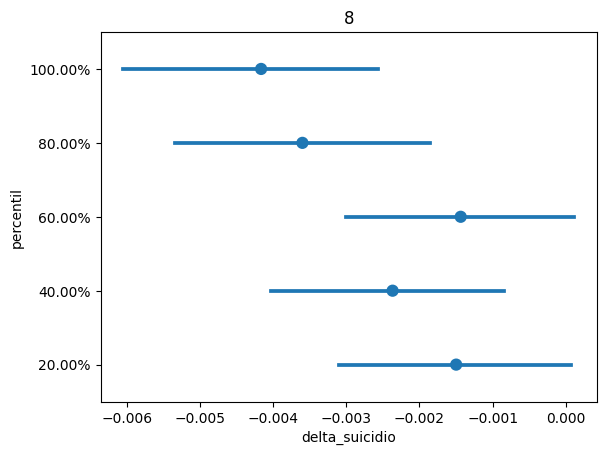

In [226]:
for n_meses in [0, 1, 3, 6, 8]:

    delta_meses = relativedelta(months=n_meses)

    mes_corte_1 = "2020-03-01"
    mes_corte_2 = "2020-04-01"

    start_date = pd.to_datetime(mes_corte_1) - delta_meses
    end_date = pd.to_datetime(mes_corte_2) + delta_meses

    print(start_date)
    print(end_date)

    df_antes = df_all[
        (df_all["date"] <= mes_corte_1) & (df_all["date"] >= start_date)
    ]
    df_depois = df_all[
        (df_all["date"] >= mes_corte_2) & (df_all["date"] <= end_date)
    ]

    colunas_relevantes = ["municipio_ibge", "valor_medio", "taxa_suicidio"]

    df_antes_mean = (
        df_antes.groupby("municipio_ibge")
        .mean()
        .reset_index()[colunas_relevantes]
    )
    df_depois_mean = (
        df_depois.groupby("municipio_ibge")
        .mean()
        .reset_index()[colunas_relevantes]
    )

    df_antes_depois = pd.merge(
        df_antes_mean, df_depois_mean, on=["municipio_ibge"]
    )
    df_antes_depois["variacao"] = (
        df_antes_depois["valor_medio_y"] - df_antes_depois["valor_medio_x"]
    )

    divisao = 5
    df_divisions = np.array_split(
        df_antes_depois.sort_values("variacao"), divisao
    )
    for i, dfs_division in enumerate(df_divisions):
        indices = dfs_division.index
        df_antes_depois.loc[indices, "percentil"] = (i / divisao) + (
            1 / divisao
        )

    df_antes_depois["delta_suicidio"] = (
        df_antes_depois["taxa_suicidio_y"] - df_antes_depois["taxa_suicidio_x"]
    )

    for i, df_percentil in enumerate(df_divisions):
        print(
            df_percentil["taxa_suicidio_y"].mean()
            - df_percentil["taxa_suicidio_x"].mean()
        )
        pass

    ax = sns.pointplot(
        data=df_antes_depois,
        x="delta_suicidio",
        y="percentil",
        join=False,
        orient="h",
        order=-np.sort(-df_antes_depois["percentil"].unique()),
    )
    y_value = [
        "{:,.2f}".format(x * 100) + "%"
        for x in -np.sort(-df_antes_depois["percentil"].unique())
    ]
    ax.set_yticklabels(y_value)
    plt.title(n_meses)
    plt.show()


2020-03-01 00:00:00
2020-04-01 00:00:00


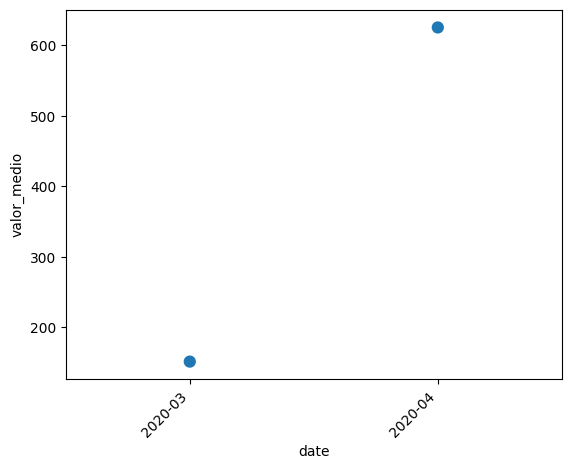

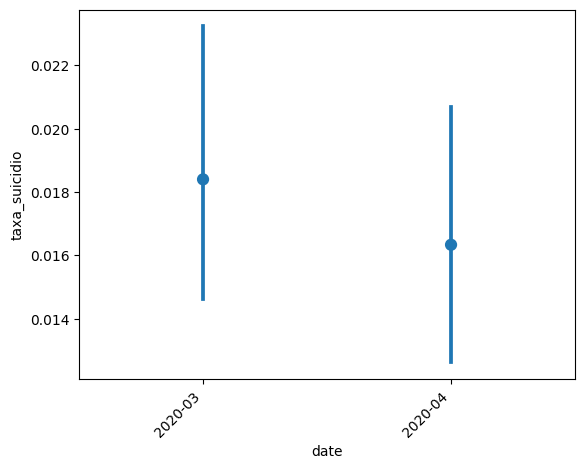

2020-02-01 00:00:00
2020-05-01 00:00:00


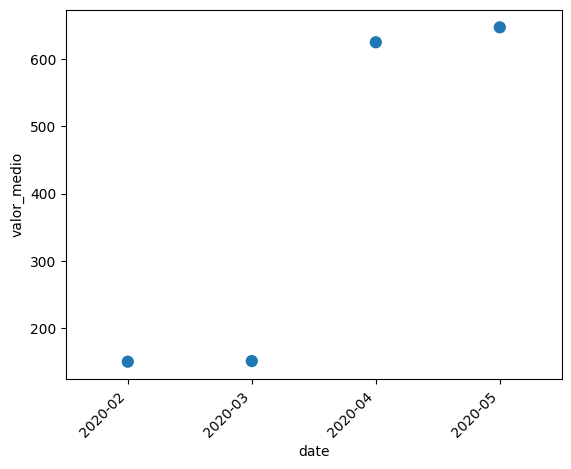

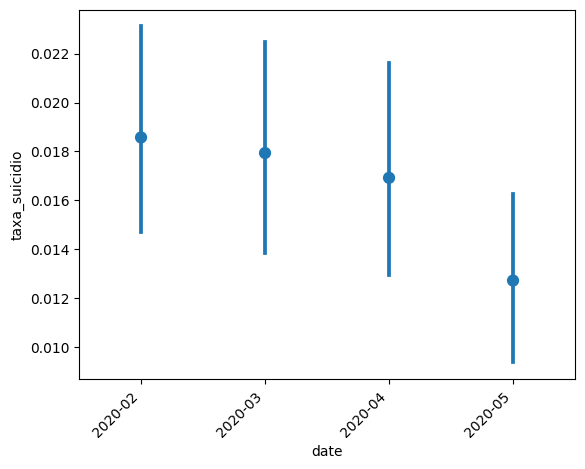

2019-12-01 00:00:00
2020-07-01 00:00:00


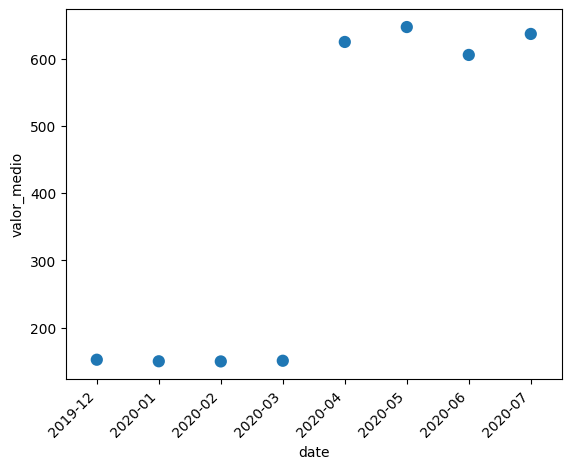

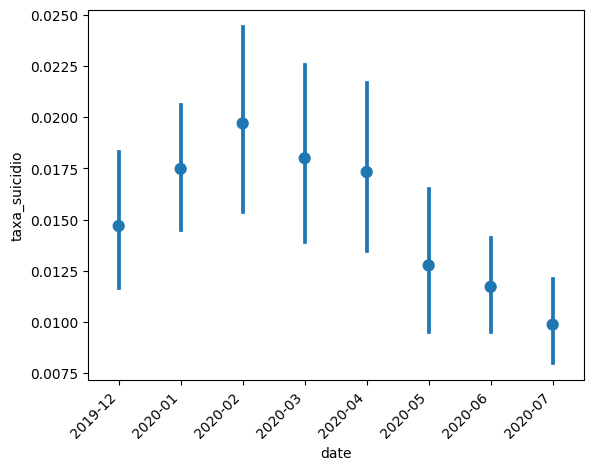

2019-09-01 00:00:00
2020-10-01 00:00:00


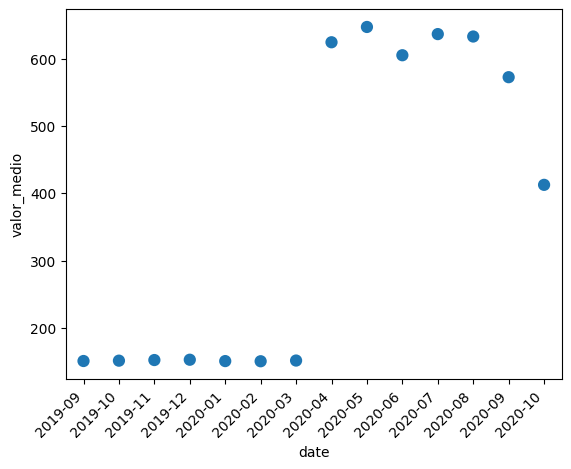

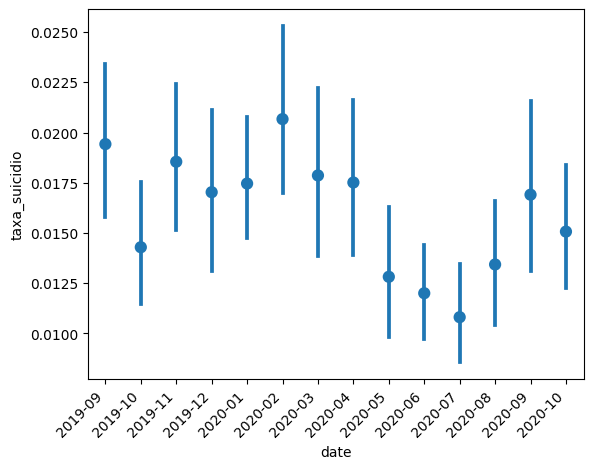

2019-07-01 00:00:00
2020-12-01 00:00:00


/home/diego/Desktop/monografia/env/lib/python3.8/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/diego/Desktop/monografia/env/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,


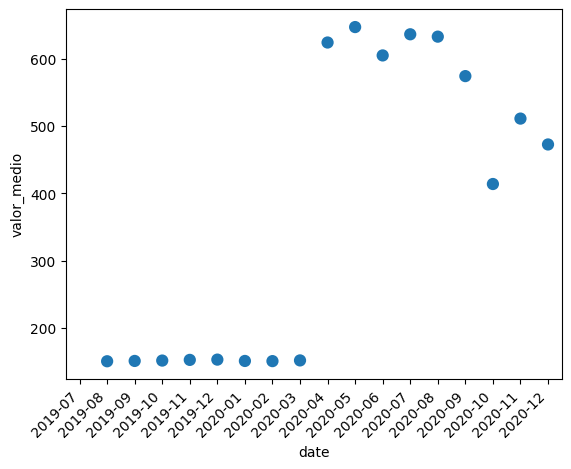

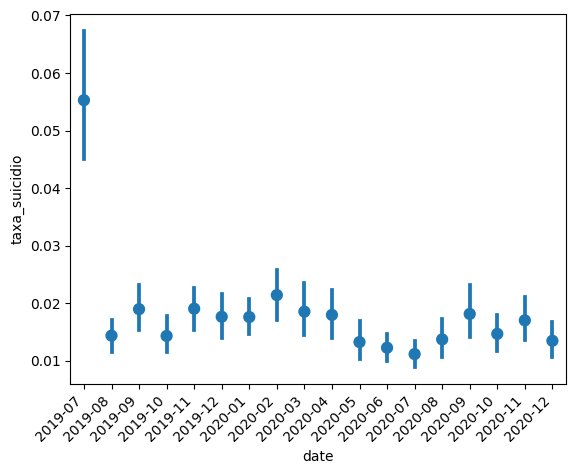

In [254]:
for n_meses in [0, 1, 3, 6, 8]:

    delta_meses = relativedelta(months=n_meses)

    mes_corte_1 = "2020-03-01"
    mes_corte_2 = "2020-04-01"

    start_date = pd.to_datetime(mes_corte_1) - delta_meses
    end_date = pd.to_datetime(mes_corte_2) + delta_meses

    print(start_date)
    print(end_date)

    df_antes = df_all[
        (df_all["date"] <= mes_corte_1) & (df_all["date"] >= start_date)
    ]
    df_depois = df_all[
        (df_all["date"] >= mes_corte_2) & (df_all["date"] <= end_date)
    ]

    colunas_relevantes = ["municipio_ibge", "valor_medio", "taxa_suicidio"]

    df_antes_mean = (
        df_antes.groupby("municipio_ibge")
        .mean()
        .reset_index()[colunas_relevantes]
    )
    df_depois_mean = (
        df_depois.groupby("municipio_ibge")
        .mean()
        .reset_index()[colunas_relevantes]
    )

    df_antes_depois = pd.merge(
        df_antes_mean, df_depois_mean, on=["municipio_ibge"]
    )
    df_antes_depois["variacao"] = (
        df_antes_depois["valor_medio_y"] - df_antes_depois["valor_medio_x"]
    )

    divisao = 5
    df_divisions = np.array_split(
        df_antes_depois.sort_values("variacao"), divisao
    )
    for i, dfs_division in enumerate(df_divisions):
        indices = dfs_division.index
        df_antes_depois.loc[indices, "percentil"] = (i / divisao) + (
            1 / divisao
        )


    maior_percentil = df_antes_depois[df_antes_depois["percentil"] == df_antes_depois["percentil"].max()][
        "municipio_ibge"
    ].unique()

    time_series_data = df_all[df_all["municipio_ibge"].isin(maior_percentil)]

    date_filter = (time_series_data["date"] >= start_date) & (time_series_data["date"] <= end_date)

    time_series_data = time_series_data[date_filter]

    ax = sns.pointplot(
        data=time_series_data, x="date", y="valor_medio", join=False, orient="v", order=np.sort(time_series_data['date'].unique())
    )
    x_dates = time_series_data['date'].dt.strftime('%Y-%m').sort_values().unique()
    ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')
    plt.show()

    ax = sns.pointplot(
        data=time_series_data, x="date", y="taxa_suicidio", join=False, orient="v", order=np.sort(time_series_data['date'].unique())
    )
    x_dates = time_series_data['date'].dt.strftime('%Y-%m').sort_values().unique()
    ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')
    plt.show()

2020-03-01 00:00:00
2020-04-01 00:00:00


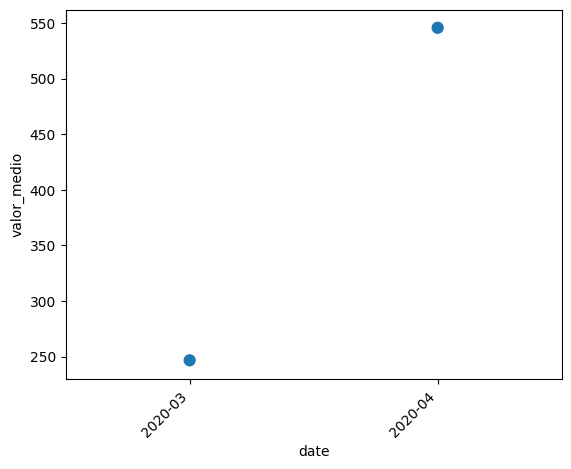

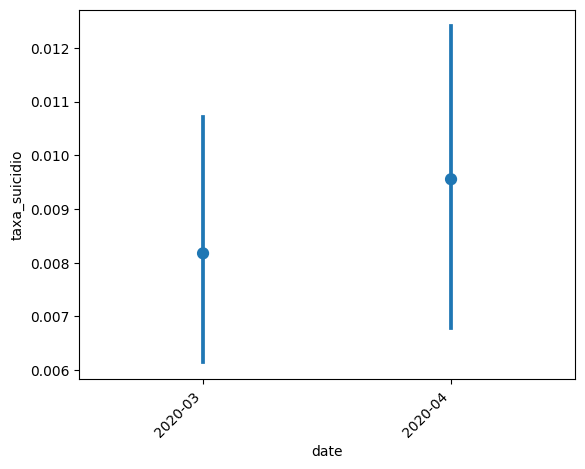

2020-02-01 00:00:00
2020-05-01 00:00:00


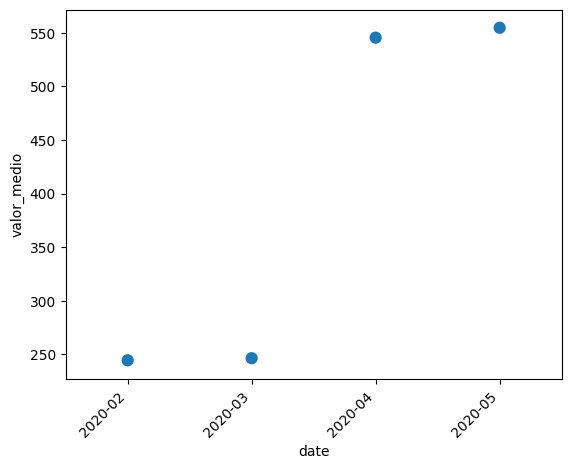

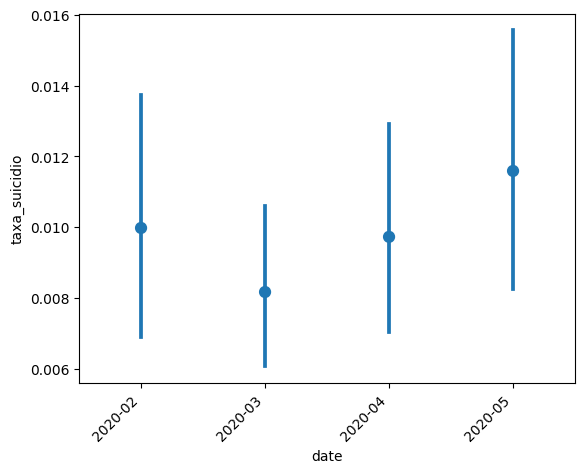

2019-12-01 00:00:00
2020-07-01 00:00:00


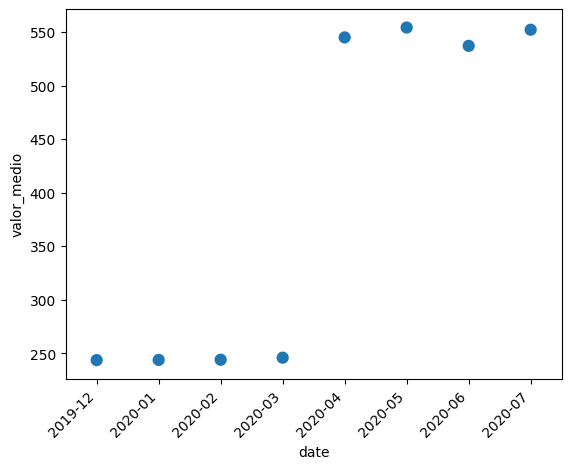

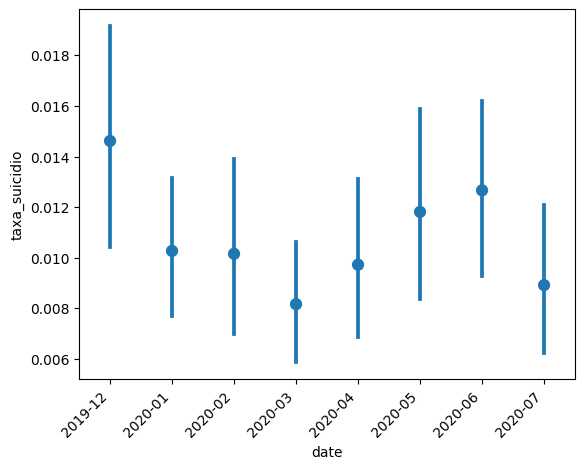

2019-09-01 00:00:00
2020-10-01 00:00:00


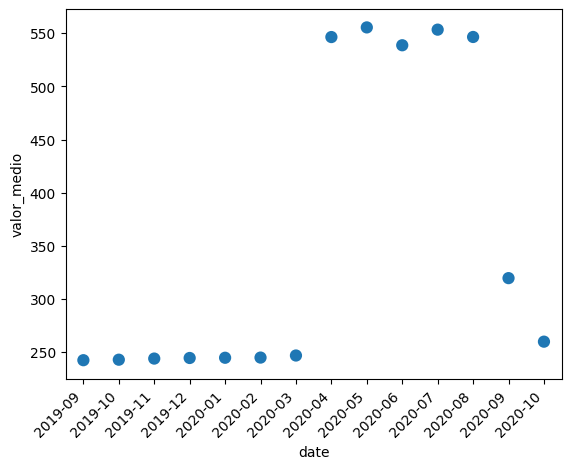

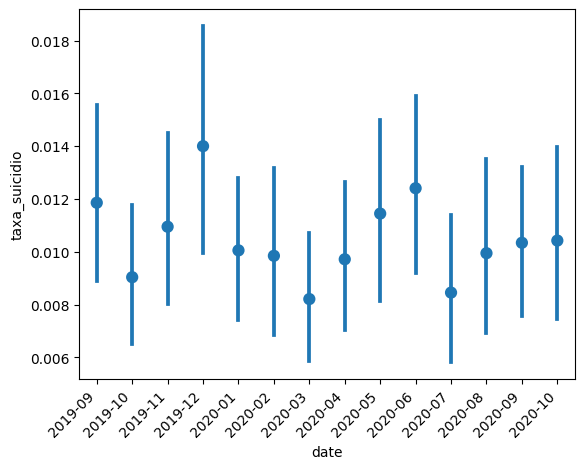

2019-07-01 00:00:00
2020-12-01 00:00:00


/home/diego/Desktop/monografia/env/lib/python3.8/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/diego/Desktop/monografia/env/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,


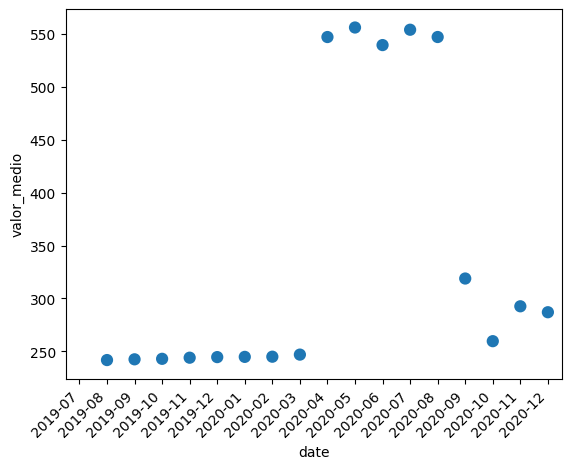

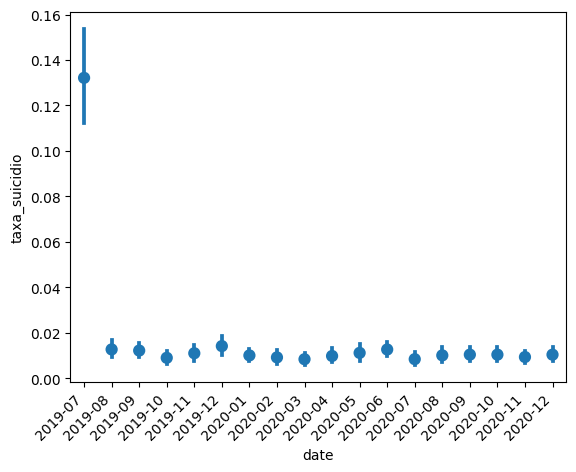

In [255]:
for n_meses in [0, 1, 3, 6, 8]:

    delta_meses = relativedelta(months=n_meses)

    mes_corte_1 = "2020-03-01"
    mes_corte_2 = "2020-04-01"

    start_date = pd.to_datetime(mes_corte_1) - delta_meses
    end_date = pd.to_datetime(mes_corte_2) + delta_meses

    print(start_date)
    print(end_date)

    df_antes = df_all[
        (df_all["date"] <= mes_corte_1) & (df_all["date"] >= start_date)
    ]
    df_depois = df_all[
        (df_all["date"] >= mes_corte_2) & (df_all["date"] <= end_date)
    ]

    colunas_relevantes = ["municipio_ibge", "valor_medio", "taxa_suicidio"]

    df_antes_mean = (
        df_antes.groupby("municipio_ibge")
        .mean()
        .reset_index()[colunas_relevantes]
    )
    df_depois_mean = (
        df_depois.groupby("municipio_ibge")
        .mean()
        .reset_index()[colunas_relevantes]
    )

    df_antes_depois = pd.merge(
        df_antes_mean, df_depois_mean, on=["municipio_ibge"]
    )
    df_antes_depois["variacao"] = (
        df_antes_depois["valor_medio_y"] - df_antes_depois["valor_medio_x"]
    )

    divisao = 5
    df_divisions = np.array_split(
        df_antes_depois.sort_values("variacao"), divisao
    )
    for i, dfs_division in enumerate(df_divisions):
        indices = dfs_division.index
        df_antes_depois.loc[indices, "percentil"] = (i / divisao) + (
            1 / divisao
        )


    menor_percentil = df_antes_depois[df_antes_depois["percentil"] == df_antes_depois["percentil"].min()][
        "municipio_ibge"
    ].unique()

    time_series_data = df_all[df_all["municipio_ibge"].isin(menor_percentil)]

    date_filter = (time_series_data["date"] >= start_date) & (time_series_data["date"] <= end_date)

    time_series_data = time_series_data[date_filter]

    ax = sns.pointplot(
        data=time_series_data, x="date", y="valor_medio", join=False, orient="v", order=np.sort(time_series_data['date'].unique())
    )
    x_dates = time_series_data['date'].dt.strftime('%Y-%m').sort_values().unique()
    ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')
    plt.show()

    ax = sns.pointplot(
        data=time_series_data, x="date", y="taxa_suicidio", join=False, orient="v", order=np.sort(time_series_data['date'].unique())
    )
    x_dates = time_series_data['date'].dt.strftime('%Y-%m').sort_values().unique()
    ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')
    plt.show()